# Electric Vehicle Charging Optimization Using Mixed Integer Linear Programming

## Table of Contents
1. [Introduction](#introduction)
2. [Problem Formulation](#problem-formulation)
3. [Mathematical Model](#mathematical-model)
4. [Implementation](#implementation)
5. [Real Data Analysis](#real-data-analysis)
6. [Results and Discussion](#results-and-discussion)

---

## 1. Introduction {#introduction}

Electric vehicle (EV) charging optimization is crucial for minimizing electricity costs while maintaining charging requirements. This tutorial demonstrates how to formulate and solve an EV charging optimization problem using Mixed Integer Linear Programming (MILP).

### Key Objectives:
- **Minimize total electricity costs** (energy charges + demand charges)
- **Satisfy charging requirements** for all EV sessions
- **Respect time constraints** and charging session windows
- **Optimize power level selection** between 1.2 kW and 7.0 kW
- **Optimize using 15-minute time intervals**

### L2 Charging Station Model:
This tutorial models a **Level 2 (L2) AC charging station** with continuously controllable power output:
- **Continuous Power Range**: 1.2 kW ≤ P ≤ 7.0 kW 
- **Optimal Power Selection**: The optimizer determines the exact optimal power level for each 15-minute charging block
- **Precise Control**: Each charging block can use any power level within the continuous range

This continuous power level approach reflects advanced L2 charging infrastructure capabilities where power can be continuously modulated through electronic control, providing maximum operational flexibility and cost optimization opportunities while maintaining realistic physical constraints.

### Background
This implementation is based on research conducted at Lawrence Berkeley National Laboratory analyzing smart charging strategies for the AlCoPark garage dataset, which included over 20,000 charging sessions from 2013-2017.

---

## 2. Problem Formulation {#problem-formulation}

### Problem Statement
Given a set of EV charging sessions with arrival/departure times and energy requirements, determine the optimal charging schedule to minimize total electricity costs under Time-of-Use (TOU) pricing.

### Key Parameters:
- **Time horizon**: From start time to (day+1) 08:00
- **Time discretization**: 15-minute intervals
- **Pricing structure**: PG&E E-19 rate schedule
- **Charging constraints**: Session time windows and energy requirements

### Decision Variables:
- $x_{i,t} \in \{0,1\}$: Binary variable indicating if session $i$ is charging at time slot $t$
- $P_{i,t} \in [1.2, 7.0]$: Continuous power level (kW) for session $i$ at time slot $t$
- $C_i \geq 0$: Completion time slot for session $i$ (latest charging time slot)
- $AP_{max,h}$: Maximum aggregate power during time period $h$

### Charging Station Specifications:
- **Level 2 (L2) AC Charging Station**
- **Continuous Power Range**: 1.2 kW ≤ P ≤ 7.0 kW
- **Flexible Charging**: Charging can occur at any time within session window
- **As Soon As Possible**: Complete charging at earliest opportunity while minimizing costs

---

## 3. Mathematical Model {#mathematical-model}

### 3.1 Objective Function

Minimize total cost consisting of energy charges and demand charges:

$\min \sum_{t=1}^{T} \left(\sum_{i=1}^{N} \sum_{j=1}^{M_i} \sum_{p \in P} p \cdot x_{i,j,t,p}\right) \cdot \Delta t \cdot \lambda(t) + \sum_{h \in H} AP_{max,h} \cdot DR_h$

Where:
- $P = \{1.2, 7.0\}$: Set of available power levels (kW)
- $p$: Power level (1.2 kW or 7.0 kW)
- $\Delta t$: Time step duration (0.25 hours)
- $\lambda(t)$: Energy rate at time $t$ ($/kWh)
- $DR_h$: Demand rate for period $h$ ($/kW)
- $H$: Set of demand charge periods {peak, part-peak, anytime}

### 3.2 Constraints

#### 3.2.1 Charging Block Scheduling
Each charging block must be scheduled exactly once with exactly one power level:

$\sum_{t=1}^{T} \sum_{p \in P} x_{i,j,t,p} = 1 \quad \forall i \in [1,N], \forall j \in [1,M_i]$

#### 3.2.2 Time Window Constraints
Charging blocks must be within session availability window:

$x_{i,j,t,p} = 0 \quad \forall t \notin [t_i^a, t_i^d], \forall i, j, p$

Where $t_i^a$ and $t_i^d$ are arrival and departure time slots for session $i$.

#### 3.2.3 Charging Order Constraints (Option A)
Maintain continuous charging order within each session:

$\sum_{t=1}^{T} \sum_{p \in P} t \cdot x_{i,j,t,p} + 1 \leq \sum_{t=1}^{T} \sum_{p \in P} t \cdot x_{i,j+1,t,p} \quad \forall i, \forall j \in [1,M_i-1]$

#### 3.2.4 Energy Requirement Constraints
Total energy delivered must meet session requirements:

$\sum_{j=1}^{M_i} \sum_{t=1}^{T} \sum_{p \in P} p \cdot x_{i,j,t,p} \cdot \Delta t = E_i \quad \forall i$

Where $E_i$ is the energy requirement for session $i$ (kWh).

#### 3.2.5 Demand Charge Constraints
Track maximum demand for each time period:

$AP_{max,h} \geq \sum_{i=1}^{N} \sum_{j=1}^{M_i} \sum_{p \in P} p \cdot x_{i,j,t,p} \quad \forall t \in T_h, \forall h \in H$

Where $T_h$ is the set of time slots in period $h$.

### 3.3 Rate Structure (PG&E E-19)

#### Summer Periods (May 1 - Oct 31):
- **Peak**: 12:00 PM - 6:00 PM
  - Energy: $0.14726/kWh
  - Demand: $18.74/kW
- **Part-Peak**: 8:30 AM-12:00 PM, 6:00 PM-9:30 PM
  - Energy: $0.10714/kWh  
  - Demand: $5.23/kW
- **Off-Peak**: All other times
  - Energy: $0.08057/kWh
- **Anytime Max Demand**: $17.33/kW

#### Winter Periods (Nov 1 - Apr 30):
- **Part-Peak**: 8:30 AM - 9:30 PM
  - Energy: $0.10166/kWh
  - Demand: $0.13/kW
- **Off-Peak**: All other times
  - Energy: $0.08717/kWh
- **Anytime Max Demand**: $17.33/kW

---

## 4. Implementation {#implementation}

Implement the optimization model step by step.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pulp
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("PuLP version:", pulp.__version__)

Libraries imported successfully!
PuLP version: 3.0.2


In [ ]:
# EVChargingOptimizer Class Definition
class EVChargingOptimizer:
    """
    Mixed Integer Linear Programming optimizer for EV charging sessions
    to minimize energy costs using 15-minute time steps.
    """
    
    def __init__(self, start_date: str = "2017-08-01"):
        """
        Initialize the optimizer with time parameters and rate structure.
        
        Args:
            start_date: Start date for optimization (YYYY-MM-DD format)
        """
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d")
        self.time_step_minutes = 15
        self.optimization_horizon_hours = 32  # Until (day+1) 08:00
        self.total_time_slots = int(self.optimization_horizon_hours * 60 / self.time_step_minutes)
        
        # L2 Charging Station Continuous Power Range
        self.min_power = 1.2  # kW: Minimum power level
        self.max_power = 7.0  # kW: Maximum power level
        
        # Create time slots from start_date 00:00 to next day 08:00
        self.time_slots = []
        current_time = self.start_date
        for i in range(self.total_time_slots):
            self.time_slots.append(current_time)
            current_time += timedelta(minutes=self.time_step_minutes)
        
        # Define rate structure based on PG&E E-19
        self.setup_rate_structure()
        
        print(f"Optimizer initialized for {start_date}")
        print(f"L2 Charging Station Power Range: {self.min_power} - {self.max_power} kW (Continuous)")
        print(f"Optimization period: {self.total_time_slots} time slots (15-min each)")
        print(f"Rate period: {'Summer' if self.is_summer else 'Winter'}")
        
    def setup_rate_structure(self):
        """Setup energy and demand charge rates based on PG&E E-19 schedule."""
        # Determine if summer or winter period
        month = self.start_date.month
        is_summer = month >= 5 and month <= 10
        
        if is_summer:
            # Summer rates (May 1 - Oct 31)
            self.energy_rates = {
                'peak': 0.14726,      # 12:00 PM - 6:00 PM
                'part_peak': 0.10714, # 8:30 AM-12:00 PM, 6:00 PM-9:30 PM
                'off_peak': 0.08057   # All other times
            }
            self.demand_rates = {
                'peak': 18.74,        # 12:00 PM - 6:00 PM
                'part_peak': 5.23,    # 8:30 AM-12:00 PM, 6:00 PM-9:30 PM
                'anytime': 17.33      # Any time
            }
        else:
            # Winter rates (Nov 1 - Apr 30)
            self.energy_rates = {
                'part_peak': 0.10166, # 8:30 AM - 9:30 PM
                'off_peak': 0.08717   # All other times
            }
            self.demand_rates = {
                'part_peak': 0.13,    # 8:30 AM - 9:30 PM
                'anytime': 17.33      # Any time
            }
        
        self.is_summer = is_summer
        
    def get_time_period(self, time_slot: datetime) -> str:
        """Determine the time-of-use period for a given time slot."""
        hour = time_slot.hour
        minute = time_slot.minute
        time_decimal = hour + minute / 60.0
        
        if self.is_summer:
            # Summer periods
            if 12.0 <= time_decimal < 18.0:  # 12:00 PM - 6:00 PM
                return 'peak'
            elif (8.5 <= time_decimal < 12.0) or (18.0 <= time_decimal < 21.5):
                return 'part_peak'
            else:
                return 'off_peak'
        else:
            # Winter periods
            if 8.5 <= time_decimal < 21.5:  # 8:30 AM - 9:30 PM
                return 'part_peak'
            else:
                return 'off_peak'


In [24]:
def load_charging_sessions(self, data: List[Dict]) -> pd.DataFrame:
    """
    Load and process charging session data for flexible L2 charging.
    
    Args:
        data: List of dictionaries with keys: 'event_id', 'start_time', 'end_time', 'energy_kwh'
    
    Returns:
        DataFrame with processed charging session data
    """
    sessions = []
    optimization_end_time = self.start_date + timedelta(hours=self.optimization_horizon_hours)
    
    for session in data:
        # Convert string times to datetime if needed
        if isinstance(session['start_time'], str):
            start_time = datetime.strptime(session['start_time'], "%Y-%m-%d %H:%M:%S")
        else:
            start_time = session['start_time']
            
        if isinstance(session['end_time'], str):
            end_time = datetime.strptime(session['end_time'], "%Y-%m-%d %H:%M:%S")
        else:
            end_time = session['end_time']
        
        # Skip sessions that don't overlap with optimization period
        if end_time <= self.start_date or start_time >= optimization_end_time:
            continue
            
        # Skip sessions with zero or negative energy
        if session['energy_charged_kWh'] <= 0:
            continue
        
        # Constrain session times to optimization window
        constrained_start = max(start_time, self.start_date)
        constrained_end = min(end_time, optimization_end_time)
        
        # Calculate session duration
        duration_hours = (end_time - start_time).total_seconds() / 3600
        session_duration_slots = int((constrained_end - constrained_start).total_seconds() / (self.time_step_minutes * 60))
        
        # Calculate minimum time needed for charging
        time_step_hours = self.time_step_minutes / 60
        min_time_needed_hours = session['energy_charged_kWh'] / self.max_power  # Using maximum power
        min_slots_needed = int(np.ceil(min_time_needed_hours / time_step_hours))
        
        # Check if session can be satisfied within time window
        if min_slots_needed > session_duration_slots:
            print(f"Warning: Session {session['event_id']} cannot be satisfied within time window")
            continue
        
        # Determine time slot indices
        start_slot = max(0, int((constrained_start - self.start_date).total_seconds() / (self.time_step_minutes * 60)))
        end_slot = min(self.total_time_slots - 1, 
                      int((constrained_end - self.start_date).total_seconds() / (self.time_step_minutes * 60)))
        
        # Skip sessions that are too short
        if end_slot <= start_slot:
            continue
        
        sessions.append({
            'event_id': session['Plug In Event Id'],
            'start_time': start_time,
            'end_time': end_time,
            'constrained_start': constrained_start,
            'constrained_end': constrained_end,
            'energy_kwh': session['energy_charged_kWh'],
            'start_slot': start_slot,
            'end_slot': end_slot,
            'duration_hours': duration_hours,
            'min_slots_needed': min_slots_needed,
            'session_duration_slots': session_duration_slots,
            'min_completion_time': start_slot + min_slots_needed - 1,
            'latest_start_slot': end_slot - min_slots_needed + 1
        })
    
    return pd.DataFrame(sessions)

# Add method to the class
EVChargingOptimizer.load_charging_sessions = load_charging_sessions

print("Add Data loading functions!")

Add Data loading functions!


In [25]:
# MILP Model Creation with Smart Charging Management
def create_milp_model(self, sessions_df: pd.DataFrame) -> Tuple[pulp.LpProblem, Dict]:
    """
    Create the Mixed Integer Linear Programming model for flexible charging optimization
    with continuous L2 power levels and early completion incentive.
    
    Args:
        sessions_df: DataFrame with charging session data
    
    Returns:
        Tuple of (optimization model, decision variables dictionary)
    """
    print("Creating MILP model with flexible charging and early completion...")
    print(f"Sessions to optimize: {len(sessions_df)}")
    print(f"Time slots: {self.total_time_slots}")
    print(f"Power range: {self.min_power} - {self.max_power} kW (Continuous)")
    
    # Create the optimization model
    model = pulp.LpProblem("EV_Charging_Flexible_Optimization", pulp.LpMinimize)
    
    # Decision variables
    charge_variables = {}    # x[session_id][time_slot] - binary charging indicator
    power_variables = {}     # P[session_id][time_slot] - continuous power level
    completion_variables = {} # C[session_id] - completion time slot
    
    total_binary_vars = 0
    total_continuous_vars = 0
    
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        charge_variables[session_id] = {}
        power_variables[session_id] = {}
        
        # Completion time variable for this session
        completion_variables[session_id] = pulp.LpVariable(
            f"C_{session_id}", lowBound=0, cat='Continuous'
        )
        total_continuous_vars += 1
        
        for t in range(self.total_time_slots):
            # Binary charging indicator
            charge_var_name = f"x_{session_id}_{t}"
            charge_variables[session_id][t] = pulp.LpVariable(charge_var_name, cat='Binary')
            total_binary_vars += 1
            
            # Continuous power variable
            power_var_name = f"P_{session_id}_{t}"
            power_variables[session_id][t] = pulp.LpVariable(
                power_var_name, lowBound=0, upBound=self.max_power, cat='Continuous'
            )
            total_continuous_vars += 1
    
    print(f"Created {total_binary_vars} binary variables and {total_continuous_vars} continuous variables")
    
    # Continuous variables for demand charges
    demand_vars = {}
    if self.is_summer:
        demand_vars['peak'] = pulp.LpVariable("max_peak_demand", lowBound=0, cat='Continuous')
        demand_vars['part_peak'] = pulp.LpVariable("max_part_peak_demand", lowBound=0, cat='Continuous')
    else:
        demand_vars['part_peak'] = pulp.LpVariable("max_part_peak_demand", lowBound=0, cat='Continuous')
    demand_vars['anytime'] = pulp.LpVariable("max_anytime_demand", lowBound=0, cat='Continuous')
    
    # Objective function: Minimize total cost + completion time penalty
    total_cost = 0
    completion_penalty_weight = 0.01  # Small weight to encourage early completion
    
    # Energy cost component
    for t, time_slot in enumerate(self.time_slots):
        period = self.get_time_period(time_slot)
        energy_rate = self.energy_rates[period]
        
        # Total power at time slot t
        total_power_t = 0
        for _, session in sessions_df.iterrows():
            session_id = session['event_id']
            total_power_t += power_variables[session_id][t]
        
        # Energy cost for this time slot (power * time_step_hours * rate)
        time_step_hours = self.time_step_minutes / 60
        total_cost += total_power_t * time_step_hours * energy_rate
    
    # Demand cost component
    for period, rate in self.demand_rates.items():
        if period in demand_vars:
            total_cost += demand_vars[period] * rate
    
    # Completion time penalty (encourage early completion)
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        total_cost += completion_penalty_weight * completion_variables[session_id]
    
    model += total_cost, "Total_Cost_Plus_Completion_Penalty"
    
    print("Adding constraints...")
    
    # Constraints
    constraint_count = 0
    
    # 1. Power level bounds: P[i,t] = 0 when x[i,t] = 0, 
    #    and min_power <= P[i,t] <= max_power when x[i,t] = 1
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        for t in range(self.total_time_slots):
            # Lower bound: P[i,t] >= min_power * x[i,t]
            model += power_variables[session_id][t] >= \
                    self.min_power * charge_variables[session_id][t], \
                    f"Power_Lower_{session_id}_{t}"
            constraint_count += 1
            
            # Upper bound: P[i,t] <= max_power * x[i,t]
            model += power_variables[session_id][t] <= \
                    self.max_power * charge_variables[session_id][t], \
                    f"Power_Upper_{session_id}_{t}"
            constraint_count += 1
    
    # 2. Charging must be within session time window
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        start_slot = session['start_slot']
        end_slot = session['end_slot']
        
        for t in range(self.total_time_slots):
            if t < start_slot or t > end_slot:
                model += charge_variables[session_id][t] == 0, \
                       f"Time_Window_{session_id}_{t}"
                constraint_count += 1
    
    # 3. Energy requirement constraints
    time_step_hours = self.time_step_minutes / 60
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        required_energy = session['energy_kwh']
        
        total_energy = pulp.lpSum([power_variables[session_id][t] * time_step_hours
                                 for t in range(self.total_time_slots)])
        
        model += total_energy == required_energy, f"Energy_Requirement_{session_id}"
        constraint_count += 1
    
    # 4. Completion time tracking constraints
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        for t in range(self.total_time_slots):
            # If charging at time t, completion time must be at least t
            model += completion_variables[session_id] >= t * charge_variables[session_id][t], \
                   f"Completion_Time_{session_id}_{t}"
            constraint_count += 1
    
    # 5. Demand charge constraints
    for t, time_slot in enumerate(self.time_slots):
        period = self.get_time_period(time_slot)
        
        # Calculate total demand at time slot t
        total_demand_t = 0
        for _, session in sessions_df.iterrows():
            session_id = session['event_id']
            total_demand_t += power_variables[session_id][t]
        
        # Update maximum demand variables
        if period in demand_vars:
            model += demand_vars[period] >= total_demand_t, \
                   f"Max_Demand_{period}_{t}"
            constraint_count += 1
        
        # Anytime maximum demand
        model += demand_vars['anytime'] >= total_demand_t, \
               f"Max_Anytime_Demand_{t}"
        constraint_count += 1
    
    print(f"Added {constraint_count} constraints")
    
    return model, charge_variables, demand_vars, power_variables, completion_variables

# Add method to the class
EVChargingOptimizer.create_milp_model = create_milp_model

print("MILP model creation function!")


MILP model creation function!


## 5. Real Data Analysis {#real-data-analysis}

Load and analyze the real charging session data from August 1, 2017.

In [17]:
# Initialize the optimizer
optimizer = EVChargingOptimizer(start_date="2017-08-01")

# Load actual charging session data
print("Loading real charging session data...")

# Load the JSON data from the file or any other source
import json
with open(f'data/chapter5/extracted_data_{'2017-08-01'}.json', 'r') as f:
    actual_data = json.load(f)
sessions_df = optimizer.load_charging_sessions(actual_data)

print(f"\nDataset Summary:")
print(f"- Total sessions loaded: {len(actual_data)}")
print(f"- Sessions for optimization: {len(sessions_df)}")
print(f"- Total energy requirement: {sessions_df['energy_kwh'].sum():.1f} kWh")
print(f"- Average session energy: {sessions_df['energy_kwh'].mean():.1f} kWh")
print(f"- Average session duration: {sessions_df['duration_hours'].mean():.1f} hours")

# Display sample sessions
print(f"\nSample charging sessions:")
display_cols = ['event_id', 'start_time', 'end_time', 'energy_kwh', 
                'min_slots_needed', 'session_duration_slots', 'min_completion_time']
display_df = sessions_df[display_cols].head()
print(display_df.to_string())

print(f"\nFlexible L2 Charging Analysis:")
time_step_hours = 0.25  # 15 minutes
energy_per_slot_min = 1.2 * time_step_hours  # kWh per 15-min slot at 1.2 kW
energy_per_slot_max = 7.0 * time_step_hours  # kWh per 15-min slot at 7.0 kW

print(f"Energy per 15-min time slot range:")
print(f"  Minimum power (1.2 kW): {energy_per_slot_min:.2f} kWh")
print(f"  Maximum power (7.0 kW): {energy_per_slot_max:.2f} kWh")
print(f"  Flexible charging: Can charge at any time within session window")
print(f"  Early completion: Optimizer incentivized to complete ASAP")

# Check feasibility for each session
print(f"\nSession Feasibility & Completion Analysis:")
for _, session in sessions_df.head().iterrows():
    earliest_completion = session['start_slot'] + session['min_slots_needed'] - 1
    latest_start = session['end_slot'] - session['min_slots_needed'] + 1
    
    print(f"Session {session['event_id']}:")
    print(f"  Energy needed: {session['energy_kwh']:.2f} kWh")
    print(f"  Min slots needed: {session['min_slots_needed']} (using 7.0 kW)")
    print(f"  Available slots: {session['session_duration_slots']}")
    print(f"  Earliest completion: Slot {earliest_completion}")
    print(f"  Latest start allowed: Slot {latest_start}")
    print(f"  Flexibility: {session['session_duration_slots'] - session['min_slots_needed']} extra slots")
    print(f"  Feasible: {'✓' if session['min_slots_needed'] <= session['session_duration_slots'] else '✗'}")



Optimizer initialized for 2017-08-01
L2 Charging Station Power Range: 1.2 - 7.0 kW (Continuous)
Optimization period: 128 time slots (15-min each)
Rate period: Summer
Loading real charging session data...

Dataset Summary:
- Total sessions loaded: 30
- Sessions for optimization: 29
- Total energy requirement: 271.4 kWh
- Average session energy: 9.4 kWh
- Average session duration: 12.0 hours

Sample charging sessions:
   event_id          start_time            end_time  energy_kwh  min_slots_needed  session_duration_slots  min_completion_time
0  77344924 2017-08-01 19:15:00 2017-08-02 01:00:00    7.230203                 5                      23                   81
1  77340858 2017-08-01 18:15:00 2017-08-02 08:30:00   12.326301                 8                      55                   80
2  77339080 2017-08-01 18:00:00 2017-08-02 07:15:00    8.411539                 5                      53                   76
3  77336462 2017-08-01 17:30:00 2017-08-01 17:45:00    0.885824         

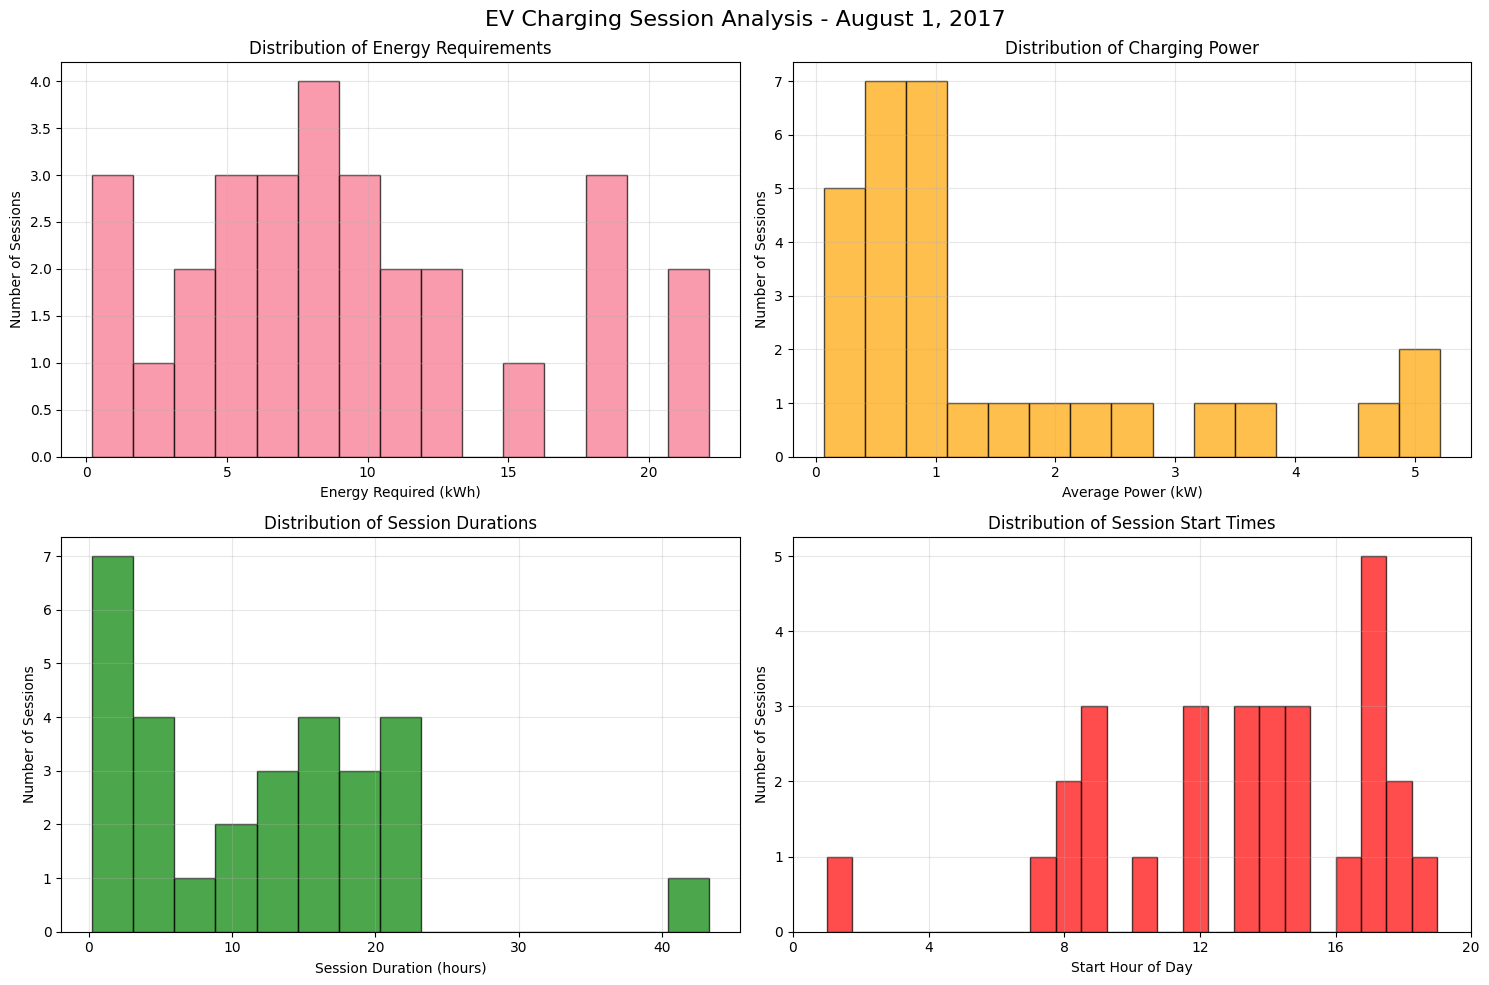

In [21]:
# Visualize Data Characteristics
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for data analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EV Charging Session Analysis - August 1, 2017', fontsize=16)

# 1. Energy distribution
axes[0,0].hist(sessions_df['energy_kwh'], bins=15, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Energy Required (kWh)')
axes[0,0].set_ylabel('Number of Sessions')
axes[0,0].set_title('Distribution of Energy Requirements')
axes[0,0].grid(True, alpha=0.3)

# 2. Power distribution
axes[0,1].hist(sessions_df['energy_kwh']/sessions_df['duration_hours'], bins=15, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].set_xlabel('Average Power (kW)')
axes[0,1].set_ylabel('Number of Sessions')
axes[0,1].set_title('Distribution of Charging Power')
axes[0,1].grid(True, alpha=0.3)

# 3. Session duration
axes[1,0].hist(sessions_df['duration_hours'], bins=15, alpha=0.7, color='green', edgecolor='black')
axes[1,0].set_xlabel('Session Duration (hours)')
axes[1,0].set_ylabel('Number of Sessions')
axes[1,0].set_title('Distribution of Session Durations')
axes[1,0].grid(True, alpha=0.3)

# 4. Start time distribution
start_hours = [t.hour for t in sessions_df['start_time']]
axes[1,1].hist(start_hours, bins=24, alpha=0.7, color='red', edgecolor='black')
axes[1,1].set_xlabel('Start Hour of Day')
axes[1,1].set_ylabel('Number of Sessions')
axes[1,1].set_title('Distribution of Session Start Times')
axes[1,1].set_xticks(range(0, 24, 4))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

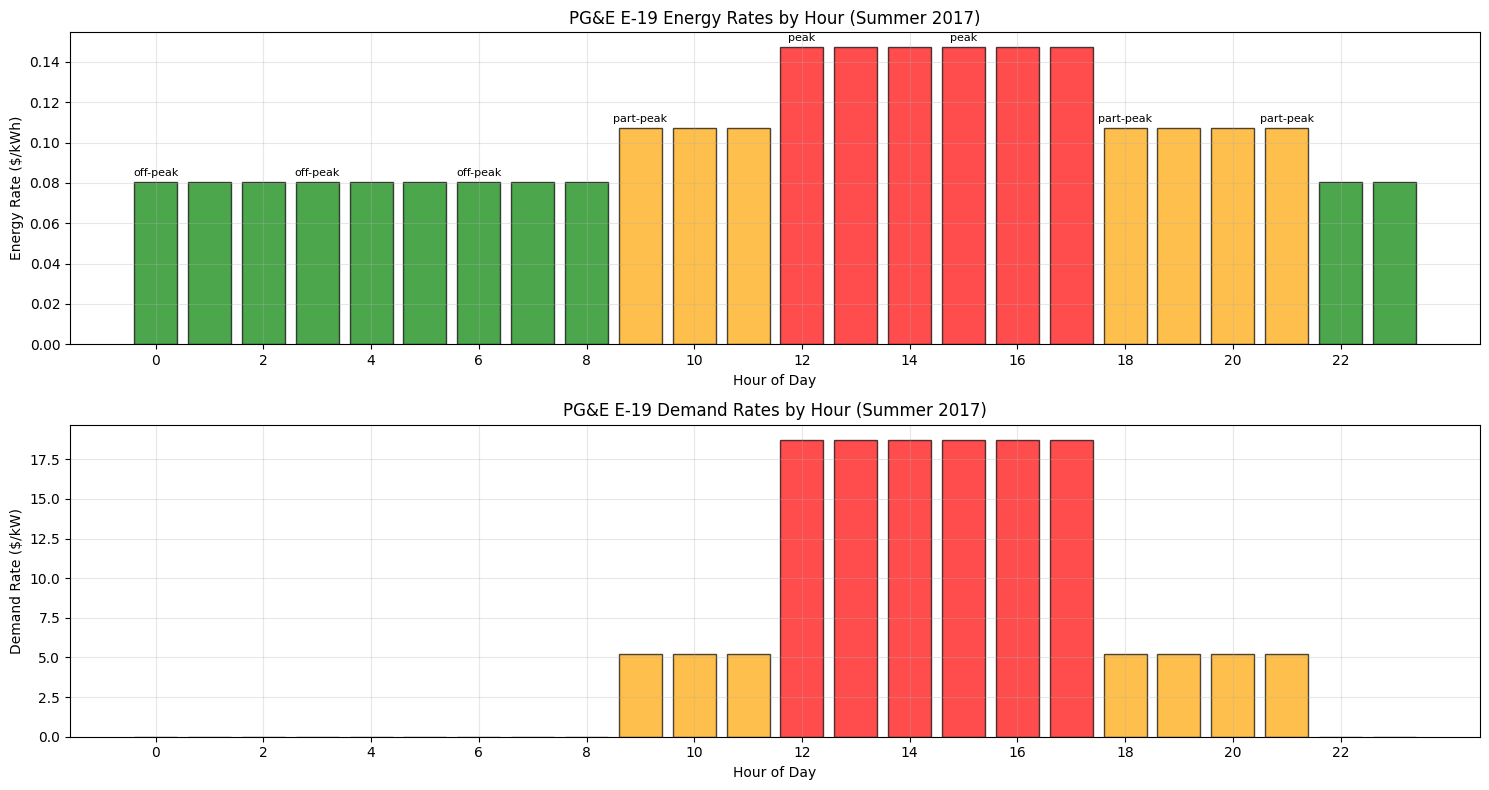

Rate Structure Summary:
Energy Rates: {'peak': 0.14726, 'part_peak': 0.10714, 'off_peak': 0.08057}
Demand Rates: {'peak': 18.74, 'part_peak': 5.23, 'anytime': 17.33}


In [22]:
# Rate Structure Visualization
# Visualize the time-of-use rate structure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Create hourly rate schedule
hours = np.arange(24)
energy_rates_hourly = []
demand_rates_hourly = []

for hour in hours:
    time_slot = optimizer.start_date.replace(hour=hour, minute=0)
    period = optimizer.get_time_period(time_slot)
    energy_rates_hourly.append(optimizer.energy_rates[period])
    demand_rates_hourly.append(optimizer.demand_rates.get(period, 0))

# Plot energy rates
colors = ['red' if r == max(optimizer.energy_rates.values()) else 
          'orange' if r == sorted(optimizer.energy_rates.values())[-2] else 'green' 
          for r in energy_rates_hourly]

ax1.bar(hours, energy_rates_hourly, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Energy Rate ($/kWh)')
ax1.set_title('PG&E E-19 Energy Rates by Hour (Summer 2017)')
ax1.set_xticks(range(0, 24, 2))
ax1.grid(True, alpha=0.3)

# Add period labels
for i, (hour, rate) in enumerate(zip(hours, energy_rates_hourly)):
    time_slot = optimizer.start_date.replace(hour=hour, minute=0)
    period = optimizer.get_time_period(time_slot).replace('_', '-')
    if i % 3 == 0:  # Show every 3rd label to avoid crowding
        ax1.text(hour, rate + 0.002, period, ha='center', va='bottom', fontsize=8)

# Plot demand rates
colors_demand = ['red' if r == max([r for r in demand_rates_hourly if r > 0]) else 
                'orange' if r > 0 and r != max([r for r in demand_rates_hourly if r > 0]) else 'green' 
                for r in demand_rates_hourly]

ax2.bar(hours, demand_rates_hourly, color=colors_demand, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Demand Rate ($/kW)')
ax2.set_title('PG&E E-19 Demand Rates by Hour (Summer 2017)')
ax2.set_xticks(range(0, 24, 2))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Rate Structure Summary:")
print("Energy Rates:", optimizer.energy_rates)
print("Demand Rates:", optimizer.demand_rates)


## 6. Results and Discussion {#results-and-discussion}

Solve the optimization problem and analyze the results.

**Note**: Due to the computational complexity of this MILP problem (28 sessions × ~60 charging blocks × 128 time slots), 
we'll solve with a subset of sessions for demonstration purposes. In practice, we can use:
- Commercial solvers (Gurobi, CPLEX) for better performance
- Rolling horizon optimization for larger datasets
- Heuristic algorithms for real-time applications

In [26]:
# Solve Optimization with Flexible Charging
def solve_optimization_demo(optimizer, sessions_df, max_sessions=3):
    """
    Solve optimization for smart charging with early completion incentive.
    """
    print(f"Solving optimization for first {max_sessions} sessions...")
    
    # Select subset for demonstration
    demo_sessions = sessions_df.head(max_sessions).copy()
    
    print(f"Demo dataset:")
    print(f"- Sessions: {len(demo_sessions)}")
    print(f"- Total energy: {demo_sessions['energy_kwh'].sum():.1f} kWh")
    print(f"- Min slots needed: {demo_sessions['min_slots_needed'].sum()}")
    print(f"- Power range: {optimizer.min_power} - {optimizer.max_power} kW (Continuous)")
    print(f"- Charging strategy: Flexible timing with early completion incentive")
    
    # Create and solve model
    model, charge_vars, demand_vars, power_vars, completion_vars = optimizer.create_milp_model(demo_sessions)
    
    print("\nSolving MILP model...")
    solver = pulp.PULP_CBC_CMD(msg=1, timeLimit=180)  # 3 minute time limit for demo
    model.solve(solver)
    
    # Extract results
    results = {
        'status': pulp.LpStatus[model.status],
        'objective_value': pulp.value(model.objective) if model.status == pulp.LpStatusOptimal else None,
        'charging_schedule': {},
        'completion_times': {},
        'demand_charges': {},
        'total_demand_by_period': {}
    }
    
    if model.status == pulp.LpStatusOptimal:
        print(f"Optimization successful!")
        print(f"Optimal objective: ${results['objective_value']:.2f}")
        
        # Extract charging schedule with flexible timing
        for _, session in demo_sessions.iterrows():
            session_id = session['event_id']
            results['charging_schedule'][session_id] = []
            
            for t in range(optimizer.total_time_slots):
                if pulp.value(charge_vars[session_id][t]) == 1:
                    power_level = pulp.value(power_vars[session_id][t])
                    results['charging_schedule'][session_id].append({
                        'time_slot': t,
                        'time': optimizer.time_slots[t],
                        'power_kw': power_level,
                        'energy_kwh': power_level * (optimizer.time_step_minutes / 60)
                    })
            
            # Extract completion time
            results['completion_times'][session_id] = pulp.value(completion_vars[session_id])
        
        # Extract demand charges
        for period, var in demand_vars.items():
            results['demand_charges'][period] = pulp.value(var)
            results['total_demand_by_period'][period] = pulp.value(var) * optimizer.demand_rates[period]
    
    else:
        print(f"Optimization failed with status: {results['status']}")
    
    return results, demo_sessions

# Run the optimization
results, demo_sessions = solve_optimization_demo(optimizer, sessions_df, max_sessions=3)


Solving optimization for first 3 sessions...
Demo dataset:
- Sessions: 3
- Total energy: 28.0 kWh
- Min slots needed: 18
- Power range: 1.2 - 7.0 kW (Continuous)
- Charging strategy: Flexible timing with early completion incentive
Creating MILP model with flexible charging and early completion...
Sessions to optimize: 3
Time slots: 128
Power range: 1.2 - 7.0 kW (Continuous)
Created 384 binary variables and 387 continuous variables
Adding constraints...
Added 1586 constraints

Solving MILP model...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ryin/myenv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/24bd7c2b27a84a9988e1cd9d109a6d29-pulp.mps -sec 180 -timeMode elapsed -branch -printingOptions all -solution /var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/24bd7c2b27a84a9988e1cd9d109a6d29-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line

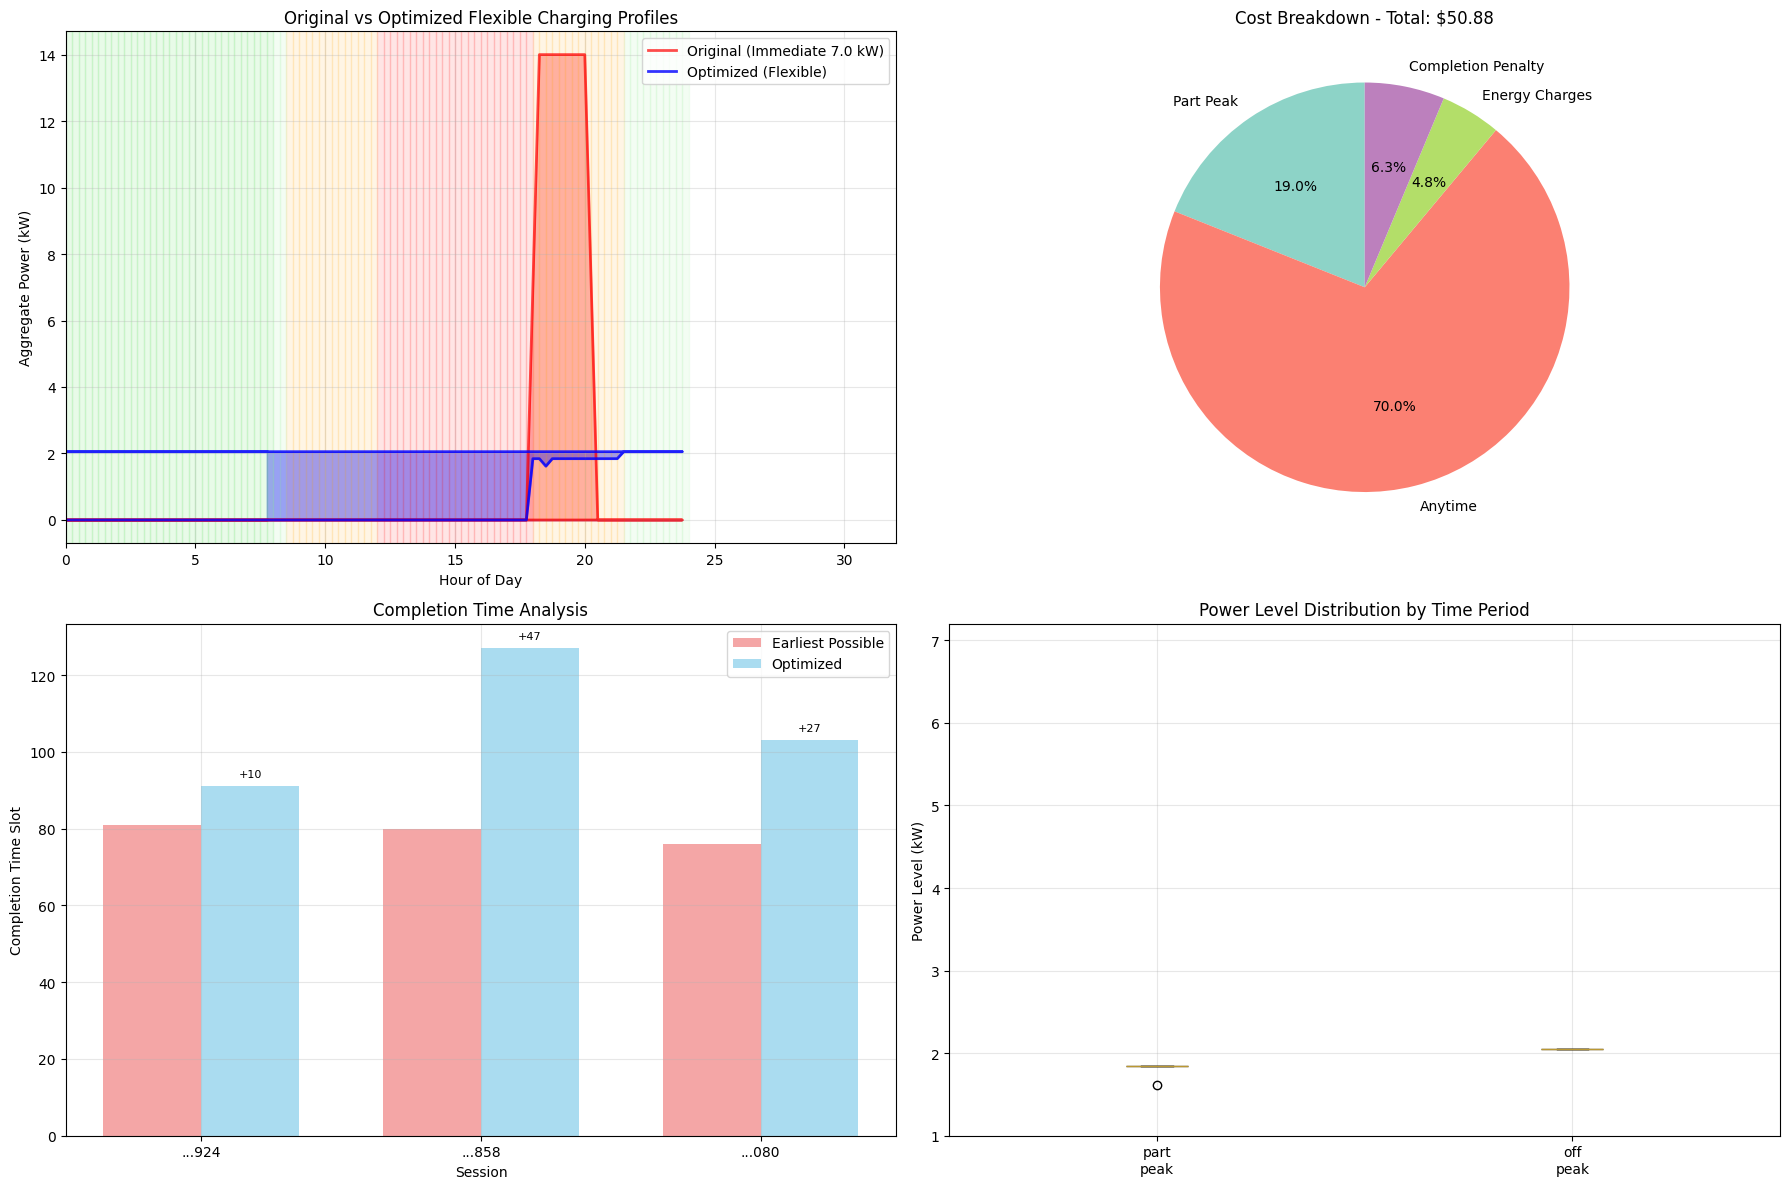


FLEXIBLE CHARGING OPTIMIZATION RESULTS
Total Cost (including completion penalty): $50.88
Energy + Demand Costs: $47.67
Completion Penalty: $3.2100

Load Profile Analysis:
Original Peak Demand: 14.0 kW
Optimized Peak Demand: 2.1 kW
Peak Reduction: 11.9 kW
Peak Reduction %: 85.3%

Power Level Statistics:
  Average Power: 2.00 kW
  Min Power Used: 1.62 kW
  Max Power Used: 2.05 kW
  Power Standard Deviation: 0.10 kW
  Total Energy Delivered: 27.97 kWh

Completion Time Analysis:
  Session 77344924:
    Earliest possible completion: Slot 81
    Actual completion: Slot 91.0
    Delay: 10 slots (2.5 hours)
  Session 77340858:
    Earliest possible completion: Slot 80
    Actual completion: Slot 127.0
    Delay: 47 slots (11.8 hours)
  Session 77339080:
    Earliest possible completion: Slot 76
    Actual completion: Slot 103.0
    Delay: 27 slots (6.8 hours)

Demand Charges by Period:
  Peak: 0.00 kW @ $18.74/kW = $0.00
  Part Peak: 1.84 kW @ $5.23/kW = $9.64
  Anytime: 2.05 kW @ $17.33/kW =

In [28]:
# Visualize Smart Charging Results
if results['status'] == 'Optimal':
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Calculate time slots in hours for plotting
    time_slots_hours = [(optimizer.start_date + timedelta(minutes=15*i)).hour + 
                       (optimizer.start_date + timedelta(minutes=15*i)).minute/60 
                       for i in range(optimizer.total_time_slots)]
    
    # Original (uncontrolled) profile - immediate charging at maximum power
    original_profile = np.zeros(optimizer.total_time_slots)
    for _, session in demo_sessions.iterrows():
        start_slot = session['start_slot']
        slots_needed = session['min_slots_needed']
        
        # Immediate charging from arrival using maximum power
        for i in range(min(slots_needed, optimizer.total_time_slots - start_slot)):
            if start_slot + i < optimizer.total_time_slots:
                original_profile[start_slot + i] += 7.0  # Maximum power
    
    # Optimized flexible charging profile
    optimized_profile = np.zeros(optimizer.total_time_slots)
    power_levels_used = []
    
    for session_id in results['charging_schedule']:
        schedule = results['charging_schedule'][session_id]
        for charge_info in schedule:
            slot = charge_info['time_slot']
            power = charge_info['power_kw']
            optimized_profile[slot] += power
            power_levels_used.append(power)
    
    # Plot 1: Original vs Optimized Load Profiles
    ax1.plot(time_slots_hours, original_profile, 'r-', linewidth=2, 
             label='Original (Immediate 7.0 kW)', alpha=0.7)
    ax1.fill_between(time_slots_hours, original_profile, alpha=0.3, color='red')
    
    ax1.plot(time_slots_hours, optimized_profile, 'b-', linewidth=2, 
             label='Optimized (Flexible)', alpha=0.8)
    ax1.fill_between(time_slots_hours, optimized_profile, alpha=0.4, color='blue')
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Aggregate Power (kW)')
    ax1.set_title('Original vs Optimized Flexible Charging Profiles')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 32)
    
    # Add time period background colors
    for i in range(len(time_slots_hours)):
        hour = time_slots_hours[i]
        time_slot = optimizer.start_date + timedelta(hours=hour)
        period = optimizer.get_time_period(time_slot)
        
        color_map = {'peak': 'red', 'part_peak': 'orange', 'off_peak': 'lightgreen'}
        if period in color_map:
            ax1.axvspan(hour, hour + 0.25, alpha=0.1, color=color_map[period])
    
    # Plot 2: Cost Breakdown
    periods = list(results['total_demand_by_period'].keys())
    demand_costs = [results['total_demand_by_period'][p] for p in periods]
    energy_cost = results['objective_value'] - sum(demand_costs) - 0.01 * sum(results['completion_times'].values())
    completion_penalty = 0.01 * sum(results['completion_times'].values())
    
    costs = demand_costs + [energy_cost, completion_penalty]
    labels = [p.replace('_', ' ').title() for p in periods] + ['Energy Charges', 'Completion Penalty']
    colors = plt.cm.Set3(np.linspace(0, 1, len(costs)))
    
    ax2.pie([c for c in costs if c > 0.001], 
           labels=[labels[i] for i, c in enumerate(costs) if c > 0.001], 
           colors=colors, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'Cost Breakdown - Total: ${results["objective_value"]:.2f}')
    
    # Plot 3: Completion Time Analysis
    session_names = []
    completion_times = []
    earliest_possible = []
    
    for session_id, completion_time in results['completion_times'].items():
        session_info = demo_sessions[demo_sessions['event_id'] == session_id].iloc[0]
        session_names.append(f"...{str(session_id)[-3:]}")
        completion_times.append(completion_time)
        earliest_possible.append(session_info['min_completion_time'])
    
    x = np.arange(len(session_names))
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, earliest_possible, width, label='Earliest Possible', 
                   color='lightcoral', alpha=0.7)
    bars2 = ax3.bar(x + width/2, completion_times, width, label='Optimized', 
                   color='skyblue', alpha=0.7)
    
    ax3.set_xlabel('Session')
    ax3.set_ylabel('Completion Time Slot')
    ax3.set_title('Completion Time Analysis')
    ax3.set_xticks(x)
    ax3.set_xticklabels(session_names)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add delay annotations
    for i, (early, actual) in enumerate(zip(earliest_possible, completion_times)):
        delay = actual - early
        if delay > 0:
            ax3.annotate(f'+{delay:.0f}', xy=(i + width/2, actual), 
                        xytext=(0, 5), textcoords='offset points', 
                        ha='center', va='bottom', fontsize=8)
    
    # Plot 4: Power vs Time Period Analysis
    power_by_period = {'peak': [], 'part_peak': [], 'off_peak': []}
    
    for session_id in results['charging_schedule']:
        schedule = results['charging_schedule'][session_id]
        for charge_info in schedule:
            period = optimizer.get_time_period(charge_info['time'])
            if period in power_by_period:
                power_by_period[period].append(charge_info['power_kw'])
    
    # Create box plot for power levels by time period
    periods_with_data = [period for period in power_by_period if power_by_period[period]]
    power_data = [power_by_period[period] for period in periods_with_data]
    
    if power_data and any(len(data) > 0 for data in power_data):
        box_plot = ax4.boxplot(power_data, labels=[p.replace('_', '\n') for p in periods_with_data], 
                              patch_artist=True)
        
        # Color the boxes
        colors_box = ['lightcoral', 'lightsalmon', 'lightgreen']
        for patch, color in zip(box_plot['boxes'], colors_box[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax4.set_ylabel('Power Level (kW)')
        ax4.set_title('Power Level Distribution by Time Period')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(optimizer.min_power - 0.2, optimizer.max_power + 0.2)
    else:
        # Fallback: simple power histogram
        if power_levels_used:
            ax4.hist(power_levels_used, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            ax4.set_xlabel('Power Level (kW)')
            ax4.set_ylabel('Frequency')
            ax4.set_title('Power Level Distribution')
            ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*80)
    print("FLEXIBLE CHARGING OPTIMIZATION RESULTS")
    print("="*80)
    
    true_energy_cost = energy_cost
    print(f"Total Cost (including completion penalty): ${results['objective_value']:.2f}")
    print(f"Energy + Demand Costs: ${results['objective_value'] - completion_penalty:.2f}")
    print(f"Completion Penalty: ${completion_penalty:.4f}")
    
    if np.max(original_profile) > 0:
        print(f"\nLoad Profile Analysis:")
        print(f"Original Peak Demand: {np.max(original_profile):.1f} kW")
        print(f"Optimized Peak Demand: {np.max(optimized_profile):.1f} kW")
        print(f"Peak Reduction: {np.max(original_profile) - np.max(optimized_profile):.1f} kW")
        print(f"Peak Reduction %: {((np.max(original_profile) - np.max(optimized_profile))/np.max(original_profile)*100):.1f}%")
    
    if power_levels_used:
        print(f"\nPower Level Statistics:")
        print(f"  Average Power: {np.mean(power_levels_used):.2f} kW")
        print(f"  Min Power Used: {np.min(power_levels_used):.2f} kW")
        print(f"  Max Power Used: {np.max(power_levels_used):.2f} kW")
        print(f"  Power Standard Deviation: {np.std(power_levels_used):.2f} kW")
        
        total_energy = sum(charge['energy_kwh'] for session_id in results['charging_schedule'] 
                          for charge in results['charging_schedule'][session_id])
        print(f"  Total Energy Delivered: {total_energy:.2f} kWh")
    
    print("\nCompletion Time Analysis:")
    for session_id, completion_time in results['completion_times'].items():
        session_info = demo_sessions[demo_sessions['event_id'] == session_id].iloc[0]
        earliest = session_info['min_completion_time']
        delay = completion_time - earliest
        print(f"  Session {session_id}:")
        print(f"    Earliest possible completion: Slot {earliest}")
        print(f"    Actual completion: Slot {completion_time}")
        print(f"    Delay: {delay:.0f} slots ({delay * 0.25:.1f} hours)")
    
    print("\nDemand Charges by Period:")
    for period, cost in results['total_demand_by_period'].items():
        demand_kw = results['demand_charges'][period]
        rate = optimizer.demand_rates[period]
        print(f"  {period.replace('_', ' ').title()}: {demand_kw:.2f} kW @ ${rate:.2f}/kW = ${cost:.2f}")
    
    print(f"\nEnergy Charges: ${true_energy_cost:.2f}")
    
    print(f"\nOptimal Flexible Charging Schedule:")
    for session_id in results['charging_schedule']:
        session_info = demo_sessions[demo_sessions['event_id'] == session_id].iloc[0]
        schedule = results['charging_schedule'][session_id]
        schedule.sort(key=lambda x: x['time_slot'])
        
        print(f"\nSession {session_id} ({session_info['energy_kwh']:.1f} kWh required):")
        print(f"  Completion: Slot {results['completion_times'][session_id]:.0f}")
        
        # Group consecutive charging periods
        if schedule:
            print(f"  Charging periods:")
            for i, charge_info in enumerate(schedule):
                power = charge_info['power_kw']
                time_str = charge_info['time'].strftime('%H:%M')
                period = optimizer.get_time_period(charge_info['time'])
                rate = optimizer.energy_rates[period]
                
                print(f"    {time_str}: {power:.2f} kW ({period}, ${rate:.4f}/kWh)")

else:
    print("Optimization failed - cannot generate visualizations")

In [29]:
# Save Results and Export Functions
def export_results_to_csv(results, sessions_df, filename="data/chapter5/optimization_results_flexible_L2.csv"):
    """Export optimization results with flexible L2 charging to CSV for further analysis."""
    if results['status'] != 'Optimal':
        print("Cannot export - optimization was not successful")
        return
    
    export_data = []
    for session_id in results['charging_schedule']:
        session_info = sessions_df[sessions_df['event_id'] == session_id].iloc[0]
        schedule = results['charging_schedule'][session_id]
        completion_time = results['completion_times'][session_id]
        
        for charge_info in schedule:
            period = optimizer.get_time_period(charge_info['time'])
            export_data.append({
                'session_id': session_id,
                'original_start': session_info['start_time'],
                'original_end': session_info['end_time'],
                'required_energy_kwh': session_info['energy_kwh'],
                'min_completion_time': session_info['min_completion_time'],
                'actual_completion_time': completion_time,
                'completion_delay_slots': completion_time - session_info['min_completion_time'],
                'scheduled_time': charge_info['time'],
                'time_slot': charge_info['time_slot'],
                'optimal_power_kw': charge_info['power_kw'],
                'slot_energy_kwh': charge_info['energy_kwh'],
                'time_period': period,
                'energy_rate_per_kwh': optimizer.energy_rates[period],
                'slot_energy_cost': charge_info['energy_kwh'] * optimizer.energy_rates[period]
            })
    
    export_df = pd.DataFrame(export_data)
    export_df.to_csv(filename, index=False)
    print(f"Results exported to {filename}")
    
    # Summary statistics
    power_levels = export_df['optimal_power_kw'].values
    completion_delays = export_df.groupby('session_id')['completion_delay_slots'].first().values
    
    print(f"\nExport Summary:")
    print(f"- Total charging time slots: {len(export_df)}")
    print(f"- Power level range: {power_levels.min():.2f} - {power_levels.max():.2f} kW")
    print(f"- Average power level: {power_levels.mean():.2f} kW")
    print(f"- Power level std dev: {power_levels.std():.2f} kW")
    print(f"- Average completion delay: {completion_delays.mean():.1f} slots")
    print(f"- Total energy: {export_df['slot_energy_kwh'].sum():.2f} kWh")
    print(f"- Total energy cost: ${export_df['slot_energy_cost'].sum():.2f}")
    
    return export_df

# Export results if optimization was successful
if results['status'] == 'Optimal':
    export_df = export_results_to_csv(results, demo_sessions, "data/chapter5/ev_optimization_flexible_L2_demo_results.csv")
    print("\nFirst few rows of exported data:")
    print(export_df.head().to_string())

Results exported to data/chapter5/ev_optimization_flexible_L2_demo_results.csv

Export Summary:
- Total charging time slots: 56
- Power level range: 1.62 - 2.05 kW
- Average power level: 2.00 kW
- Power level std dev: 0.10 kW
- Average completion delay: 28.0 slots
- Total energy: 27.97 kWh
- Total energy cost: $2.42

First few rows of exported data:
   session_id      original_start        original_end  required_energy_kwh  min_completion_time  actual_completion_time  completion_delay_slots      scheduled_time  time_slot  optimal_power_kw  slot_energy_kwh time_period  energy_rate_per_kwh  slot_energy_cost
0    77344924 2017-08-01 19:15:00 2017-08-02 01:00:00             7.230203                   81                    91.0                    10.0 2017-08-01 19:15:00         77          1.843835         0.460959   part_peak              0.10714          0.049387
1    77344924 2017-08-01 19:15:00 2017-08-02 01:00:00             7.230203                   81                    91.0       

### In this notebook:
1. **MILP Formulation**: How to formulate EV charging as a mixed-integer optimization problem
2. **Time-of-Use Optimization**: Shifting charging from peak to off-peak periods reduces costs
3. **Demand Charge Management**: Controlling peak demand is crucial for large facilities
4. **Real Data Application**: Applied to actual charging session data from AlCoPark garage

### Potential Extensions:
1. **Larger Scale**: Use commercial solvers (Gurobi, CPLEX) for full datasets
2. **Uncertainty Handling**: Stochastic programming for uncertain arrival/departure times
3. **Demand Response**: Integration with utility demand response programs
4. **Real-Time Control**: Rolling horizon optimization for online implementation

### Computational Considerations:
- **Problem Size**: Scales as O(sessions × blocks × time_slots)
- **Solution Time**: Can be significant for large instances
- **Memory Requirements**: Binary variables consume substantial memory
- **Alternative Approaches**: Heuristics, decomposition methods for scalability

### References
R. Yin, B. Wang and D. Black. “Characteristics of Electric Vehicle Charging Sessions and its
Benefits in Managing Peak Demands of a Commercial Building”. In: IEEE International Conference
on Smart Grid Communications (SmartGridComm), Virtual Conference, 11-13 November 2020.

